### Packages

In [1]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csc_matrix, hstack
import lightgbm as lgb
from sklearn.metrics import f1_score
import gc
import os
import re

%matplotlib inline

### Read data

In [2]:
train = pd.read_csv('../data/dataframe/train.csv')
test = pd.read_csv('../data/dataframe/test.csv')

### Feature extraction

In [3]:
def text_cleaner(text):
    
    text = re.sub(r'[^a-z]+', ' ', text.lower())
    return(text)

In [4]:
### english
tf_en = TfidfVectorizer(ngram_range=(1,10), max_features=25000, preprocessor=text_cleaner)
tf_en.fit(train[train.type == "english"].text.tolist())

### french
tf_fr = TfidfVectorizer(ngram_range=(1,10), max_features=25000, preprocessor=text_cleaner)
tf_fr.fit(train[train.type == "french"].text.tolist())

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=25000, min_df=1,
        ngram_range=(1, 10), norm='l2',
        preprocessor=<function text_cleaner at 0x7ff4758a1620>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None)

extraire uniquement les stopwords en anglais et francais car tfidf est censé les écarter naturellement

In [5]:
X = hstack([tf_en.transform(train.text.tolist()), tf_fr.transform(train.text.tolist())])

y = [1 if x == 'english' else 0 for x in train.type.tolist()]

columns = list(tf_en.vocabulary_) + list(tf_fr.vocabulary_)

Xtest = hstack([tf_en.transform(test.text.tolist()), tf_fr.transform(test.text.tolist())])

In [6]:
gc.collect()

0

### Machine learning

In [7]:
lgbTrain = lgb.Dataset(X, y, feature_name = columns, free_raw_data = True)

In [8]:
params = {'objective': 'binary',
          'learning_rate' : 0.1}

# https://stackoverflow.com/questions/50931168/f1-score-metric-in-lightgbm
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

In [9]:
lgbCv = lgb.cv(params, lgbTrain,
               num_boost_round = 150, stratified = True,
               shuffle = True, nfold = 10, feval = lgb_f1_score, verbose_eval = 10, seed = 2701)

[10]	cv_agg's f1: 0.896088 + 0.0181614	cv_agg's binary_logloss: 0.353085 + 0.0165223
[20]	cv_agg's f1: 0.898295 + 0.0188153	cv_agg's binary_logloss: 0.27055 + 0.022467
[30]	cv_agg's f1: 0.899197 + 0.0179329	cv_agg's binary_logloss: 0.243784 + 0.0244512
[40]	cv_agg's f1: 0.903292 + 0.014575	cv_agg's binary_logloss: 0.234832 + 0.0240525
[50]	cv_agg's f1: 0.902468 + 0.015708	cv_agg's binary_logloss: 0.232081 + 0.0270755
[60]	cv_agg's f1: 0.902689 + 0.0146661	cv_agg's binary_logloss: 0.233418 + 0.0280358
[70]	cv_agg's f1: 0.905232 + 0.014164	cv_agg's binary_logloss: 0.237057 + 0.0286937
[80]	cv_agg's f1: 0.905016 + 0.0115553	cv_agg's binary_logloss: 0.241458 + 0.0308586
[90]	cv_agg's f1: 0.905436 + 0.0125003	cv_agg's binary_logloss: 0.24766 + 0.0327531
[100]	cv_agg's f1: 0.905809 + 0.0114351	cv_agg's binary_logloss: 0.253576 + 0.0330366
[110]	cv_agg's f1: 0.905461 + 0.0106695	cv_agg's binary_logloss: 0.259679 + 0.034959
[120]	cv_agg's f1: 0.902715 + 0.0103133	cv_agg's binary_logloss: 0.266

In [10]:
bestIter = int(lgbCv['f1-mean'].index(max(lgbCv['f1-mean']))/(1-1/10))
bestIter

91

In [11]:
lgbModel = lgb.train(params, lgbTrain, num_boost_round = bestIter)

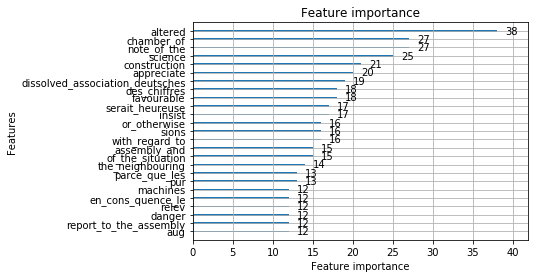

In [12]:
lgb.plot_importance(lgbModel, max_num_features = 25)

### Predict and save

In [13]:
test['en'] = np.round(lgbModel.predict(Xtest))
test['fr'] = 1 - test['en']

/home/dataexmachina/DataProjects/CrowdAI/ONU_DigitalizationChallenge/crowdai-venv/lib/python3.5/site-packages/lightgbm/basic.py:448: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [14]:
test.head()

,id,text,en,fr
0,56d0687284da6482faaa4a9afede7722,"DLiasus O° NATIONS.\n\nveneva, Mereh 20th, 193...",1.0,0.0
1,8e988cca9bab61b6ef4c1ae5b742c5aa,nowonts\n\nNombres-indices par rapport aux chi...,1.0,0.0
2,b6e026cc2c57ae5c3cf0dd19ddd607b0,\n\nPEERS.\n\n \n\n \n\nko further l¢zislatio...,1.0,0.0
3,e0aff017251bc023e4ff44fd8b701456,"Sea\n\nThe construction of 2,742 houses repres...",1.0,0.0
4,5e484277809181c2c873beffffda182c,<p\n\nBudget (continued) -\n\nMonthly (continu...,1.0,0.0


In [15]:
test = test[['id', 'en', 'fr']]
test.columns = ['filename', 'en', 'fr']
test['filename'] = list(map(lambda x: x+'.jpg', test.filename.tolist()))

In [16]:
try:
    os.mkdir('../submit')
except: None
    
test.to_csv('../submit/lgb2.csv', index = False)

In [17]:
test.head()

,filename,en,fr
0,56d0687284da6482faaa4a9afede7722.jpg,1.0,0.0
1,8e988cca9bab61b6ef4c1ae5b742c5aa.jpg,1.0,0.0
2,b6e026cc2c57ae5c3cf0dd19ddd607b0.jpg,1.0,0.0
3,e0aff017251bc023e4ff44fd8b701456.jpg,1.0,0.0
4,5e484277809181c2c873beffffda182c.jpg,1.0,0.0
